In [17]:
from torch_geometric.data import Data
import torch
import numpy as np
from torch_geometric.utils import to_undirected

In [18]:
edge_index = torch.tensor([[3,5,6,2,4],[5,3,2,6,6]],dtype=torch.long)
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[1,33,4],[12, 4, 2]],dtype=torch.float)
y = torch.tensor([0,1,0,1,0,0,1],dtype=torch.long)
edge_index = to_undirected(edge_index)
data = Data(x=x,edge_index=edge_index,y=y)

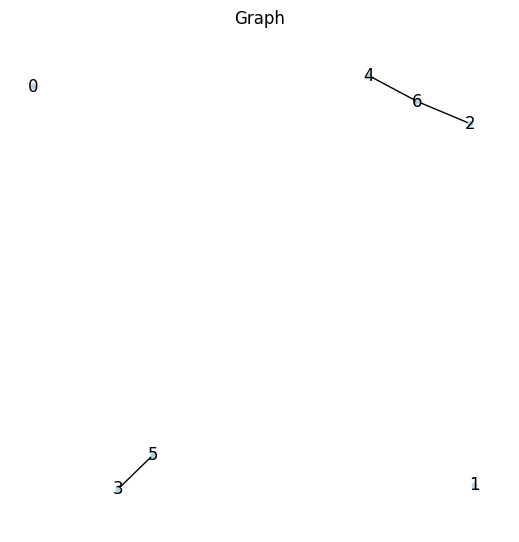

In [19]:
#convert graph to networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

#convert to networkx with node attributes
G = to_networkx(data, to_undirected=True)
#plot
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10,node_color='lightblue',with_labels=True)
plt.title('Graph')
plt.show()


In [13]:
from torch_geometric.utils import *

H = subgraph(edge_index=data.edge_index, subset=[[1,2,4,6]], relabel_nodes=False)

In [20]:
H = data.subgraph(torch.tensor([1,2,4,6]))

In [21]:
data.edge_index

tensor([[2, 3, 4, 5, 6, 6],
        [6, 5, 6, 3, 2, 4]])

In [22]:
H.edge_index

tensor([[1, 2, 3, 3],
        [3, 3, 1, 2]])

In [14]:
data.edge_index

tensor([[3, 5, 6, 2, 4],
        [5, 3, 2, 6, 6]])

In [15]:
H

(tensor([[6, 2, 4],
         [2, 6, 6]]),
 None)

In [16]:
data.x

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [13., 14., 15.],
        [ 1., 33.,  4.],
        [12.,  4.,  2.]])

In [17]:
#create a new x tensor with node 1,2,4,6
data.x[[1,2,4,6]]


tensor([[ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [13., 14., 15.],
        [12.,  4.,  2.]])

In [18]:
list_of_nodes = [1,2,4,6]
#convert to numpy ndarray
import numpy as np
list_of_nodes = np.array(list_of_nodes)

In [13]:
A = [1, 2, 4, 5, 7]
B = [0, 6, 3, 2]
any(j in A for j in B)

True

In [17]:
#Find which is common in A and B
import numpy as np
np.intersect1d(A,B).item() 

2

In [29]:
import time
import torch
from torch_geometric.data import Data

# Original function

def neighbors_cpu(G, nodes):
    if not hasattr(G, 'edge_index'):
        raise ValueError("The input graph must have the 'edge_index' attribute.")

    # Convert nodes to a tensor if it's not already
    if not isinstance(nodes, torch.Tensor):
        nodes = torch.tensor(nodes)

    # Ensure nodes tensor is on CPU
    nodes = nodes.cpu()

    # Ensure edge_index tensor is on CPU
    edge_index_cpu = G.edge_index.cpu()

    # Find edges connected to the given nodes using broadcasting
    mask = (edge_index_cpu[0] == nodes.unsqueeze(-1)).any(dim=0)
    edges_connected_to_nodes = edge_index_cpu[:, mask]

    # Extract neighboring nodes
    neighbors = torch.unique(edges_connected_to_nodes[1])

    return neighbors.tolist()
# Optimized GPU function
def neighbors_gpu(G, nodes):
    if not hasattr(G, 'edge_index'):
        raise ValueError("The input graph must have the 'edge_index' attribute.")

    # Convert nodes to a tensor if it's not already
    if not isinstance(nodes, torch.Tensor):
        nodes = torch.tensor(nodes)

    # Ensure nodes tensor is on GPU
    nodes = nodes.to(G.edge_index.device)

    # Ensure edge_index tensor is on GPU
    edge_index_gpu = G.edge_index.to(nodes.device)

    # Find edges connected to the given nodes using broadcasting
    mask = (edge_index_gpu[0] == nodes.unsqueeze(-1)).any(dim=0)
    edges_connected_to_nodes = edge_index_gpu[:, mask]

    # Extract neighboring nodes
    neighbors = torch.unique(edges_connected_to_nodes[1])

    return neighbors.tolist() # Move the result back to CPU and convert to list

# Create a random graph with more nodes and edges
num_nodes = 10
edge_index = torch.randint(0, num_nodes, (2, 2*num_nodes))

#convert G to undirected graph
from torch_geometric.utils import to_undirected
edge_index = to_undirected(edge_index)
G = Data(edge_index=edge_index)
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset', name='cora')
#G = dataset[0]
# Choose a node for testing
node = [0]

# Measure execution time for the original function
start_time = time.time()
neighbours_original = neighbors_cpu(G, node)
original_time = time.time() - start_time

# Measure execution time for the optimized GPU function
start_time = time.time()
neighbours_optimized_gpu = neighbors_gpu(G, node)
optimized_gpu_time = time.time() - start_time

print("Original function execution time:", original_time)
print("Optimized GPU function execution time:", optimized_gpu_time)


Original function execution time: 0.0003380775451660156
Optimized GPU function execution time: 0.00018143653869628906


In [30]:
neighbours_optimized_gpu, neighbours_original

([2, 6, 7], [2, 6, 7])

In [35]:
# Create tensors A and B
A = torch.tensor([1, 2, 4, 5])
B = torch.tensor([3, 4, 6])

# Concatenate tensors A and B along dimension 0
C = torch.cat((A, B), dim=0)

In [38]:
#elements in B which are not in A
D = B[~B.isin(A)]
D

AttributeError: 'Tensor' object has no attribute 'isin'

In [39]:
import torch

A = torch.tensor([1, 2, 4, 5])
B = torch.tensor([3, 4, 6])

# Find elements in B that are not in A
not_in_A = B[~torch.isin(B, A)]

print(not_in_A)


tensor([3, 6])
